# Propensity modeling for Santander Customer Transaction


## Importing libraries



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import pandas as pd
from tqdm import tqdm
from datetime import datetime
import missingno as msno
import numpy as np
import time
import gc

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, make_scorer, classification_report, confusion_matrix, roc_curve
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
import lightgbm as lgb
from sklearn.cluster import FeatureAgglomeration
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import IPython.display
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
from IPython.core.display import display, HTML, Javascript
from string import Template



/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Loading and optimizing data

In [3]:
def reduce_mem_usage(df, verbose=True):
  """ iterate through all the columns of a dataframe and modify the data type
      to reduce memory usage.        
  """    
  numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
  start_mem = df.memory_usage().sum() / 1024**2    
  print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))    
  
  for col in df.columns:
      col_type = df[col].dtypes
      if col_type in numerics:
          c_min = df[col].min()
          c_max = df[col].max()
          if str(col_type)[:3] == 'int':
              if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                  df[col] = df[col].astype(np.int8)
              elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                  df[col] = df[col].astype(np.int16)
              elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                  df[col] = df[col].astype(np.int32)
              elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                  df[col] = df[col].astype(np.int64)  
          else:
              if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                  df[col] = df[col].astype(np.float16)
              elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                  df[col] = df[col].astype(np.float32)
              else:
                  df[col] = df[col].astype(np.float64)
                  
  end_mem = df.memory_usage().sum() / 1024**2
  print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
  print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
  return df

In [13]:
df = pd.read_csv('drive/My Drive/Colab Notebooks/Santander Customer Transaction Prediction/data/resampled_train.csv')
# df.drop(['ID_code'], axis=1, inplace=True)
df = reduce_mem_usage(df, verbose=True)

Memory usage of dataframe is 450.83 MB
Memory usage after optimization is: 112.43 MB
Decreased by 75.1%


In [14]:
df.columns

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
       ...
       '191', '192', '193', '194', '195', '196', '197', '198', '199',
       'target'],
      dtype='object', length=201)

In [15]:
df.isnull().sum()

0         0
1         0
2         0
3         0
4         0
         ..
196       0
197       0
198       0
199       0
target    0
Length: 201, dtype: int64

## Data Sampling

In [16]:
df_x = df.drop(['target'], axis=1)
df_y = df[['target']]
features = list(df_x.columns.values)

X_train, X_test, Y_train, Y_test = train_test_split(df_x, df_y, shuffle=False, train_size=0.8)

In [7]:
X_train.shape, X_test.shape

((470374, 200), (117594, 200))

In [17]:
def evaluate(y_true, y_predicted):
  print("area under the ROC curve:", roc_auc_score(y_true, y_predicted))
  print(classification_report(y_true, y_predicted))
  print(confusion_matrix(y_true, y_predicted))

  auc = roc_auc_score(y_true, y_predicted)
  fpr, tpr, thresholds = roc_curve(y_true, y_predicted, pos_label=1)

  plt.plot(fpr, tpr)
  plt.plot([0, 1], [0, 1], '--')
  plt.xlim(0, 1.01)
  plt.ylim(0, 1.01)
  plt.title('AUC: {}'.format(round(auc, 2)))

In [18]:
folds = StratifiedKFold(n_splits=7, shuffle=True, random_state=47)
oof = np.zeros(X_train.shape[0])
getVal = np.zeros(X_train.shape[0])
predictions = np.zeros(X_test.shape[0])
feature_importance_df = pd.DataFrame()

In [ ]:
for n_fold, (train_idx, valid_idx) in enumerate(folds.split(X_train, Y_train)):

    train_x, train_y = X_train.iloc[train_idx], Y_train.iloc[train_idx]
    valid_x, valid_y = X_train.iloc[valid_idx], Y_train.iloc[valid_idx]

    train_data = lgb.Dataset(train_x, label=train_y)
    valid_data = lgb.Dataset(valid_x, label=valid_y)

    param = {
        "objective": "binary",
        "metric": "auc",
        "boosting": 'gbdt',
        "max_depth": -1,
        "num_leaves": 31,
        "learning_rate": 0.01,
        "bagging_freq": 5,
        "bagging_fraction": 0.4,
        "feature_fraction": 0.05,
        "min_data_in_leaf": 150,
        "min_sum_heassian_in_leaf": 10,
        "tree_learner": "serial",
        "boost_from_average": "false",
        "bagging_seed": 42,
        "verbosity": 1,
        "seed": 42}

    clf = lgb.train(param, train_data, 1000000, valid_sets=[train_data, valid_data], verbose_eval=500,
                    early_stopping_rounds=200)
    oof[valid_idx] = clf.predict(X_train.iloc[valid_idx], num_iteration=clf.best_iteration)
    getVal[valid_idx] += clf.predict(X_train.iloc[valid_idx], num_iteration=clf.best_iteration) / folds.n_splits

    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = n_fold + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

    predictions += clf.predict(X_test, num_iteration=clf.best_iteration) / folds.n_splits

Training until validation scores don't improve for 200 rounds.
[500]	training's auc: 0.925928	valid_1's auc: 0.918081
[1000]	training's auc: 0.937472	valid_1's auc: 0.928268
[1500]	training's auc: 0.946696	valid_1's auc: 0.936143
[2000]	training's auc: 0.953749	valid_1's auc: 0.942195
[2500]	training's auc: 0.959064	valid_1's auc: 0.946479
[3000]	training's auc: 0.963192	valid_1's auc: 0.949873
[3500]	training's auc: 0.966649	valid_1's auc: 0.952561
[4000]	training's auc: 0.969568	valid_1's auc: 0.954681
[4500]	training's auc: 0.972166	valid_1's auc: 0.956564
[5000]	training's auc: 0.97446	valid_1's auc: 0.958093
[5500]	training's auc: 0.976542	valid_1's auc: 0.959508
[6000]	training's auc: 0.978446	valid_1's auc: 0.960774
[6500]	training's auc: 0.980214	valid_1's auc: 0.961999
[7000]	training's auc: 0.981829	valid_1's auc: 0.963104
[7500]	training's auc: 0.983325	valid_1's auc: 0.964121
[8000]	training's auc: 0.984709	valid_1's auc: 0.964994
[8500]	training's auc: 0.986016	valid_1's a

In [ ]:
cols = (feature_importance_df[["feature", "importance"]]
            .groupby("feature")
            .mean()
            .sort_values(by="importance", ascending=False)[:1000].index)
best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

plt.figure(figsize=(14, 26))
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
plt.title('LightGBM Features (averaged over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

In [ ]:
print("CV score (Validation): {:<8.5f}".format(roc_auc_score(Y_train, oof)))
print("CV score (Test): {:<8.5f}".format(roc_auc_score(Y_test, predictions)))

CV score (Validation): 0.89736 
CV score (Test): 0.90237 


In [ ]:
y_pred = np.zeros(predictions.shape[0])
y_pred[predictions >= 0.1] = 1
evaluate(Y_test, y_pred)

In [ ]:
threshold_data = []
for t in np.linspace(0.05, 0.15, num=1000):

  y_pred = np.zeros(predictions.shape[0])
  y_pred[predictions >= t] = 1
  auc = roc_auc_score(Y_test, y_pred)
  threshold_data.append([t, auc])

threshold_df = pd.DataFrame(threshold_data, columns=['Threshold', 'AUC'])

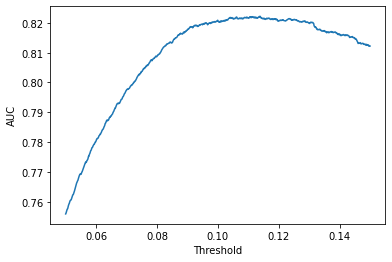

In [ ]:
sns.lineplot(x="Threshold", y="AUC", data=threshold_df)

In [ ]:
threshold_df.describe()

,Threshold,AUC
count,1000.000000,1000.000000
mean,0.100000,0.809011
std,0.028911,0.016811
min,0.050000,0.755886
25%,0.075000,0.803697
50%,0.100000,0.816691
75%,0.125000,0.820629
max,0.150000,0.822238


In [ ]:
best_threshold = threshold_df.loc[threshold_df['AUC'].idxmax(), 'Threshold']

area under the ROC curve: 0.8222375054424775
              precision    recall  f1-score   support

           0       0.98      0.83      0.90     35951
           1       0.35      0.82      0.49      4049

    accuracy                           0.83     40000
   macro avg       0.66      0.82      0.69     40000
weighted avg       0.91      0.83      0.86     40000

[[29811  6140]
 [  748  3301]]


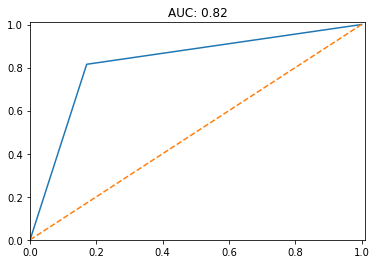

In [ ]:
y_pred = np.zeros(predictions.shape[0])
y_pred[predictions >= best_threshold] = 1
evaluate(Y_test, y_pred)